In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd 
import keras 
from tensorflow.keras.utils import to_categorical
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow import keras
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras 

Mounted at /content/drive


# ***Load the Dataset***

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/test/Datasetfor1peakszeroimputations (1).csv')
df = df.iloc[38:]

In [ ]:
df.drop(df.tail(145).index, inplace = True) 

In [ ]:
##finding the index and the max of consecutive 1's
arr = list(df['label'])
count = 0
prev = 0
indexend = 0
for i in range(0,len(arr)):
    if arr[i] == 1:
        count += 1
    else:            
      if count > prev:
        prev = count
        indexend = i
      count = 0

print("The longest sequence of 1's is "+str(prev))
print("index start at: "+ str(indexend-prev))
print("index ends at: "+ str(indexend-1))

The longest sequence of 1's is 128
index start at: 137895
index ends at: 138022


# ***TRAIN DATASET***

In [ ]:
from scipy.signal import find_peaks
import numpy as np
from scipy import stats
from scipy.signal import find_peaks

df['label'] = df['label'].astype('category')
df['label'] = df['label'].cat.codes
df['subj_id'] = df['subj_id'].astype('category')   
df['subj_id'] = df['subj_id'].cat.codes             

In [ ]:
len(df.subj_id.unique())

32

In [ ]:
# df_train =  df[df.subj_id.isin( df.subj_id.unique()[:25] ) ]  #selecting 25 subjects for training
#Seventy percent for training data - 96831 but took 97004 so its 70.0125 so i.e., out of 477 whole strides 334 full strides are selected - which is 668 left and right combined strides. 
df_train = df.loc[:97004] 

# WINDOWING WITH NON OVERLAPPING WINDOWS with size 145
xs = []
ys = []
zs = []
train_labels = []
new_list = []
window_size = 145
step_size = 145

for i in range(0, df.shape[0] - window_size, step_size):
  xs = df['x'].values[i: i + 145]
  ys = df['y'].values[i: i + 145]
  zs = df['z'].values[i: i + 145]

  label = df['label'].values[i: i + 145][0] 
  a = np.c_[ xs,ys,zs ]
  new_list.append(a)
  train_labels.append(label)

train_x = np.asarray(new_list)
train_y = np.asarray(train_labels)

# ***TEST DATA***

In [ ]:
# df_test =  df[df.subj_id.isin( df.subj_id.unique()[25:] ) ]  #selecting 6 subjects for testing
# df_test =  df[df.subj_id.isin( df.subj_id.unique()[25:] ) ]  #selecting 6 subjects for testing
df_test = df.loc[97004:] #30percent 
xs = []
ys = []
zs = []
test_labels = []
new_list = []
window_size = 145
step_size = 145

for i in range(0, df_test.shape[0] - window_size, step_size):
  xs = df_test['x'].values[i: i + 145]
  ys = df_test['y'].values[i: i + 145]
  zs = df_test['z'].values[i: i + 145]

  label = df_test['label'].values[i: i + 145][0] 
  a = np.c_[ xs,ys,zs ]
  new_list.append(a)
  test_labels.append(label)

test_x = np.asarray(new_list)
test_y = np.asarray(test_labels)

# ***EVALUATION***

# ***CNN***

In [ ]:
from keras import regularizers

In [ ]:
#Accuracy 56

from keras.regularizers import l2

model_cnn3 = Sequential() 

model_cnn3.add(Conv1D(filters=160, kernel_size=2, activation='relu', input_shape=(145,3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

model_cnn3.add(Conv1D(filters=128, kernel_size=2, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

model_cnn3.add(Flatten())
model_cnn3.add(Dropout(0.7))

model_cnn3.add(Dense(1,activation='sigmoid'))

model_cnn3.compile(loss='binary_crossentropy', optimizer="adam", metrics = ["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
model_cnn3.summary()

#_________
model_cnn3.fit(train_x, train_y, epochs=50, batch_size=1000, verbose=1)
#________
scores = model_cnn3.evaluate(test_x,test_y, verbose=1)
 
print(scores) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 160)          1120      
                                                                 
 conv1d_1 (Conv1D)           (None, 143, 128)          41088     
                                                                 
 flatten (Flatten)           (None, 18304)             0         
                                                                 
 dropout (Dropout)           (None, 18304)             0         
                                                                 
 dense (Dense)               (None, 1)                 18305     
                                                                 
Total params: 60,513
Trainable params: 60,513
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1/1 [==============================] - 9s

# ***EXP***

In [ ]:
from keras.regularizers import l2

from keras.callbacks import ReduceLROnPlateau

rlrop = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=100)

model_cnn4 = Sequential() 
model_cnn4.add(Conv1D(filters=160, kernel_size=2, activation='relu', input_shape=(145,3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn4.add(Conv1D(filters=128, kernel_size=2, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn4.add(Flatten())
model_cnn4.add(Dropout(0.7))
model_cnn4.add(Dense(1,activation='sigmoid'))

model_cnn4.compile(loss='binary_crossentropy', optimizer="adam", metrics = ["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
model_cnn4.summary()

#_________
model_cnn4.fit(train_x, train_y, epochs=50, batch_size=1000, verbose=1,callbacks=[rlrop])
#________
scores = model_cnn4.evaluate(test_x,test_y, verbose=1)
scores

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 144, 160)          1120      
                                                                 
 conv1d_3 (Conv1D)           (None, 143, 128)          41088     
                                                                 
 flatten_1 (Flatten)         (None, 18304)             0         
                                                                 
 dropout_1 (Dropout)         (None, 18304)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 18305     
                                                                 
Total params: 60,513
Trainable params: 60,513
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1/1 [==============================] - 

[2.2107973098754883, 0.5641025900840759, 0.9411764740943909, 0.5]

## ***EXP7***

In [ ]:
from keras.regularizers import l2
# import noise layer
from keras.layers import GaussianNoise
# define noise layer
layer = GaussianNoise(0.1)

model_cnn6 = Sequential() 
model_cnn6.add(Conv1D(filters=160, kernel_size=2, activation='relu', input_shape=(145,3) , kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn6.add(GaussianNoise(0.1))
model_cnn6.add(Conv1D(filters=128, kernel_size=2, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn6.add(GaussianNoise(0.1))
model_cnn6.add(Flatten())
model_cnn6.add(Dropout(0.7))
model_cnn6.add(GaussianNoise(0.1))
model_cnn6.add(Dense(1,activation='sigmoid'))

model_cnn6.compile(loss='binary_crossentropy', optimizer="adam", metrics = ["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
model_cnn6.summary()

#_________
model_cnn6.fit(train_x, train_y, epochs=50, batch_size=1000, verbose=1, validation_split=0.2)
#________
scores = model_cnn6.evaluate(test_x,test_y, verbose=1)
 
scores 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 144, 160)          1120      
                                                                 
 gaussian_noise_15 (Gaussian  (None, 144, 160)         0         
 Noise)                                                          
                                                                 
 conv1d_13 (Conv1D)          (None, 143, 128)          41088     
                                                                 
 gaussian_noise_16 (Gaussian  (None, 143, 128)         0         
 Noise)                                                          
                                                                 
 flatten_6 (Flatten)         (None, 18304)             0         
                                                                 
 dropout_6 (Dropout)         (None, 18304)            

[1.7822399139404297,
 0.6666666865348816,
 0.29411765933036804,
 0.8333333134651184]

In [ ]:
from keras.regularizers import l2

model_cnn7 = Sequential() 
model_cnn7.add(Conv1D(filters=160, kernel_size=2, activation='relu', input_shape=(145,3) , kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn7.add(GaussianNoise(0.5))
model_cnn7.add(Conv1D(filters=128, kernel_size=2, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn7.add(GaussianNoise(0.5))
# model_cnn7.add(GaussianNoise(0.5))
model_cnn7.add(Flatten())
model_cnn7.add(Dropout(0.7))
model_cnn7.add(GaussianNoise(0.25))
model_cnn7.add(Dense(1,activation='sigmoid'))
model_cnn7.compile(loss='binary_crossentropy', optimizer="adam", metrics = ["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
model_cnn7.summary()
#_________
model_cnn7.fit(train_x, train_y, epochs=50, batch_size=1000, verbose=1, validation_split=0.2)
#________
scores = model_cnn7.evaluate(test_x,test_y, verbose=1)
scores

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 144, 160)          1120      
                                                                 
 gaussian_noise_11 (Gaussian  (None, 144, 160)         0         
 Noise)                                                          
                                                                 
 conv1d_11 (Conv1D)          (None, 143, 128)          41088     
                                                                 
 gaussian_noise_12 (Gaussian  (None, 143, 128)         0         
 Noise)                                                          
                                                                 
 flatten_5 (Flatten)         (None, 18304)             0         
                                                                 
 dropout_5 (Dropout)         (None, 18304)            

[2.49460768699646, 0.692307710647583, 0.29411765933036804, 1.0]

In [ ]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
actual = test_y 
pred = model_cnn7.predict(test_x) 
predicted = np.argmax(pred, axis = 1)

In [ ]:
# confusion matrix
matrix = confusion_matrix(actual,predicted, labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,predicted,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[ 87  59]
 [ 29 109]]
Outcome values : 
 87 59 29 109
Classification report : 
               precision    recall  f1-score   support

           1       0.75      0.60      0.66       146
           0       0.65      0.79      0.71       138

    accuracy                           0.69       284
   macro avg       0.70      0.69      0.69       284
weighted avg       0.70      0.69      0.69       284



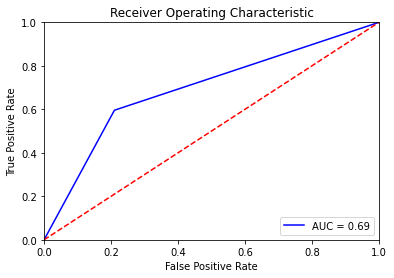

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(actual, predicted)
roc_auc = metrics.auc(fpr, tpr)
 
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()